# Chapter6 機械学習の基礎

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from nltk.stem.porter import PorterStemmer as PS
import os
import seaborn as sns

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer

In [4]:
! ls drive

'My Drive'


In [0]:
base_dir = "./drive/My Drive/chap06".replace('/', os.sep)

In [0]:
data = pd.read_csv(base_dir+"/NewsAggregatorDataset/newsCorpora.csv",sep="\t",header=None)

In [7]:
data.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')

### column名の追加

In [0]:
data.columns=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP']

In [9]:
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


### 情報源の抽出

In [0]:
publisher={'Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'}

In [0]:
data = data[data['PUBLISHER'].isin(publisher)]

In [12]:
data['PUBLISHER'].unique()

array(['Reuters', 'Businessweek', 'Huffington Post', 'Daily Mail',
       'Contactmusic.com'], dtype=object)

### ランダムな並び替え

In [0]:
data_shuffled = data.sample(frac=1, random_state=0)

In [14]:
data_shuffled.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
310638,311098,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,b,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597
49197,49198,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,e,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417
410059,410578,"UPDATE 1-Fairfax Financial, CEO probed over po...",http://in.reuters.com/article/2014/08/01/fairf...,Reuters,b,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070
270222,270668,Angelina Jolie - Angelina Jolie Will Not Tight...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,e,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205
301196,301656,Patent Officials Cancel the Washington Redskin...,http://www.businessweek.com/articles/2014-06-1...,Businessweek,b,dXVU3KhKpHSxleMNmc46pQj6e5zwM,www.businessweek.com,1403113194649


### trainとtestにsplit

In [0]:
TRAIN_FILE=base_dir+"/data/train.txt"
TEST_FILE=base_dir+"/data/test.txt"

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_data,test_data = train_test_split(data_shuffled,test_size=0.1)

In [0]:
#train_data.to_csv(TRAIN_FILE,sep="\t")
#test_data.to_csv(TEST_FILE,sep="\t")

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12006 entries, 194066 to 404958
Data columns (total 8 columns):
ID           12006 non-null int64
TITLE        12006 non-null object
URL          12006 non-null object
PUBLISHER    12006 non-null object
CATEGORY     12006 non-null object
STORY        12006 non-null object
HOSTNAME     12006 non-null object
TIMESTAMP    12006 non-null int64
dtypes: int64(2), object(6)
memory usage: 844.2+ KB


In [20]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 61060 to 276407
Data columns (total 8 columns):
ID           1334 non-null int64
TITLE        1334 non-null object
URL          1334 non-null object
PUBLISHER    1334 non-null object
CATEGORY     1334 non-null object
STORY        1334 non-null object
HOSTNAME     1334 non-null object
TIMESTAMP    1334 non-null int64
dtypes: int64(2), object(6)
memory usage: 93.8+ KB


In [21]:
train_data.isnull().all()

ID           False
TITLE        False
URL          False
PUBLISHER    False
CATEGORY     False
STORY        False
HOSTNAME     False
TIMESTAMP    False
dtype: bool

In [22]:
test_data.isnull().all()

ID           False
TITLE        False
URL          False
PUBLISHER    False
CATEGORY     False
STORY        False
HOSTNAME     False
TIMESTAMP    False
dtype: bool

In [23]:
category = train_data.groupby(["CATEGORY"]).count()["ID"]
category

CATEGORY
b    5065
e    4763
m     822
t    1356
Name: ID, dtype: int64

# 51 特徴量抽出

使えそうなcolumn

In [0]:
features=["TITLE","HOSTNAME"]

In [0]:
train_target = train_data["CATEGORY"]
train_feature = train_data[features]

In [26]:
train_target.unique() # categoryは4種類

array(['e', 'b', 'm', 't'], dtype=object)

In [27]:
train_feature["HOSTNAME"].unique()

array(['www.contactmusic.com', 'www.reuters.com', 'in.reuters.com',
       'www.businessweek.com', 'www.huffingtonpost.com',
       'www.dailymail.co.uk'], dtype=object)

## 出版社ごとのカテゴリ

In [0]:
category_publisher_data = train_data[['PUBLISHER','CATEGORY',"ID"]]
category_count = category_publisher_data.groupby(["CATEGORY","PUBLISHER"]).count()

In [29]:
category_count

ID
CATEGORY PUBLISHER             
b        Businessweek      1649
         Contactmusic.com     2
         Daily Mail         186
         Huffington Post    385
         Reuters           2843
e        Businessweek        78
         Contactmusic.com  2087
         Daily Mail        1323
         Huffington Post   1113
         Reuters            162
m        Businessweek       118
         Contactmusic.com    10
         Daily Mail         229
         Huffington Post    296
         Reuters            169
t        Businessweek       311
         Contactmusic.com    10
         Daily Mail         285
         Huffington Post    406
         Reuters            344

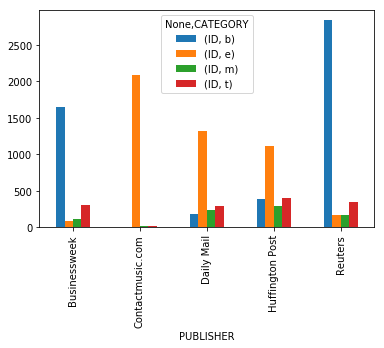

In [30]:
category_count.unstack(level=0).plot(kind='bar')

## 使う特徴量
* Title
* HOSTNAME(ロイターに二種類あるから)

In [0]:
features=["TITLE","HOSTNAME"]

In [0]:
train_feature = train_data[features]

In [0]:
train_target = train_data["CATEGORY"]

### PUBLISHER
* publisherをdummy変数にする

### HOSTNAME

In [0]:
def dummy_hostname(df):
    ret_df = pd.get_dummies(df,columns=['HOSTNAME'])
    return ret_df

### TITLE

In [0]:
def remove_num(s):
    return re.sub(r'\d+','',s)

In [36]:
remove_num('highlights from the 2014 costume institute gal...')

'highlights from the  costume institute gal...'

In [0]:
import string
def remove_punc(s):
    punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^','\n'
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
    
    for p in punct:
        s = s.replace(p,"")
    return s

In [38]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = stopwords.words('english')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def remove_stop_word(s)->list:
        ret=[c for c in s.split(" ") if c and  not c in stop_words ]
        return " ".join(ret)

In [0]:
def stem_word(s_l):
    ps = PS()
    return " ".join([ps.stem(word) for word in s_l.split(" ")])

In [0]:
def preprocess_str(s):
    s = remove_num(s)
    s = remove_punc(s)
    s = s.lower()
    s = remove_stop_word(s)
    s = stem_word(s)
    return s

In [0]:
def preprocess_title(df):
    df["TITLE"] = df["TITLE"].apply(preprocess_str)
    return df

In [0]:
def add_len_col(df):
    df['LEN'] = df['TITLE'].apply(len)
    return df

## PreProcessing to train data

In [0]:
train_feature = dummy_hostname(train_feature)

In [0]:
train_feature = preprocess_title(train_feature)

In [46]:
train_feature.head()

,TITLE,HOSTNAME_in.reuters.com,HOSTNAME_www.businessweek.com,HOSTNAME_www.contactmusic.com,HOSTNAME_www.dailymail.co.uk,HOSTNAME_www.huffingtonpost.com,HOSTNAME_www.reuters.com
194066,kim kardashian kim kardashian narrow wed gown,0,0,1,0,0,0
192302,updat emir profit soar higher sale cheaper fuel,0,0,0,0,0,1
11517,rooney mara cast tiger lili peter pan origin m...,0,0,1,0,0,0
22752,mick jagger issu singl statement regard lover ...,0,0,1,0,0,0
201797,kim kardashian kany west yet sign prenup,0,0,1,0,0,0


# tf_idf の高い語を特徴量に

In [0]:
count = CountVectorizer()
bag = count.fit_transform(train_feature["TITLE"])

In [0]:
# tfidfの設定
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
# 小数点第4位まで表示する．
np.set_printoptions(precision=4)
cnt_voc = count.vocabulary_
tfidf_array = np.array(tfidf.fit_transform(bag).toarray())

# ベクトルと単語を対応づけるために必要な処理．
vec = DictVectorizer()
vec.fit_transform(cnt_voc).toarray()
feature = vec.get_feature_names()

In [0]:
# tfidfの閾値の設定
threshold = 0.5
hairetsu = np.where(tfidf_array >= threshold)
# np.uniqueで重複する値を削除する．
# なぜかnp.whereだと二つの配列が返ってくるので，連結して一つにする．
hit_word = np.unique(np.append(hairetsu[0], hairetsu[1]))

# tfidfで計算された単語を出力する．
key_word=[]
for c in hit_word:
    if len(feature)>c:
        key_word.append(feature[c])


In [0]:
for w in key_word:
    train_feature[w]=  train_feature['TITLE'].map(lambda x:1 if w in x.split(" ") else 0)

In [51]:
train_feature.head()

,TITLE,HOSTNAME_in.reuters.com,HOSTNAME_www.businessweek.com,HOSTNAME_www.contactmusic.com,HOSTNAME_www.dailymail.co.uk,HOSTNAME_www.huffingtonpost.com,HOSTNAME_www.reuters.com,aa,aaliyah,aatha,ab,abandon,abbvi,abbvieshir,abdi,abdullah,abe,abercrombi,abil,abl,aboard,abram,abroad,absenc,abu,abus,abyss,acb,acceler,accentu,access,accommod,accord,account,acdc,acid,ackman,acl,acm,acquisit,...,yeah,year,yearago,yearend,yearonyear,yellen,yelp,yoga,york,young,your,youth,youv,yovanna,yr,yryr,yuan,yuppi,yy,zac,zach,zaki,zamperini,zap,zayn,zebra,zendaya,zeppelin,zero,zeu,zew,zier,zillow,zimmerman,zion,zip,zoe,zooey,zoosk,zuckerberg
194066,kim kardashian kim kardashian narrow wed gown,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192302,updat emir profit soar higher sale cheaper fuel,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11517,rooney mara cast tiger lili peter pan origin m...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22752,mick jagger issu singl statement regard lover ...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
201797,kim kardashian kany west yet sign prenup,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train_feature = train_feature.drop("TITLE",axis=1)

In [53]:
train_feature.values

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## process test data

In [0]:
test_target = test_data["CATEGORY"]
test_feature = test_data[features]

In [0]:
test_feature = dummy_hostname(test_feature)

In [0]:
test_feature = preprocess_title(test_feature)

In [0]:
for w in key_word:
    test_feature[w]=  test_feature['TITLE'].map(lambda x:1 if w in x.split(" ") else 0)

In [0]:
test_feature = test_feature.drop("TITLE",axis=1)

In [0]:
#train_feature.to_csv(TRAIN_FEATURE_FILE,sep="\t")
#test_feature.to_csv(TEST_FEATURE_FILE,sep="\t")

# 52 学習

In [0]:
train_target = train_target.replace({"e":1,"b":2,"t":3,"m":4}) # 1つずつ個別に指定

In [0]:
test_target = test_target.replace({"e":1,"b":2,"t":3,"m":4}) # 1つずつ個別に指定

In [0]:
import sklearn.linear_model

In [64]:
clf = sklearn.linear_model.LogisticRegression(C=100)
clf.fit(train_feature,train_target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
clf.coef_

array([[-3.8402e+00, -3.2123e+00,  6.4011e+00, ...,  5.8027e-03,
        -3.7893e+00, -5.0508e+00],
       [ 2.8756e+00,  2.5149e+00, -7.8465e+00, ..., -3.8009e-02,
         8.8909e-01, -2.6659e+00],
       [ 5.7460e-03, -3.2379e-03, -3.9055e+00, ..., -7.0221e-04,
        -6.8910e-03,  6.2437e+00],
       [-1.4654e+00, -1.2687e-01, -3.3269e+00, ..., -1.1069e-03,
        -1.6346e-03, -1.7687e+00]])

# 53 予測

In [66]:
clf.predict(test_feature)

array([2, 2, 2, ..., 1, 1, 2])

# 正解率の計測

In [67]:
clf.score(test_feature,test_target)

0.876311844077961

# 55　混同行列の作成

In [0]:
from sklearn.metrics import confusion_matrix

### train_data

In [0]:
train_pred = clf.predict(train_feature)
train_true = train_target

In [70]:
cfm_data=confusion_matrix(train_pred,train_true)
cfm_data

array([[4747,    8,    8,    8],
       [  12, 5001,   63,   19],
       [   2,   48, 1283,    3],
       [   2,    8,    2,  792]])

In [0]:
labels=["e","b","t","m"]

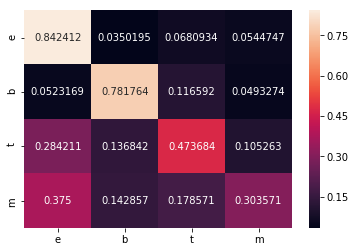

In [102]:
df_cfm = pd.DataFrame(cfm_data,index=labels,columns=labels)
df_cfm= df_cfm.astype('float') / df_cfm.sum(axis=1)[:, np.newaxis]
sns.heatmap(df_cfm,fmt="g",annot=True)
plt.show()

### test_data

In [0]:
labels=["e","b","t","m"]

In [0]:
y_pred = clf.predict(test_feature)
y_true = test_target

In [100]:
cfm_data=confusion_matrix(y_pred,y_true)
cfm_data= cfm_data.astype('float') / cfm_data.sum(axis=1)[:, np.newaxis]
cfm_data

array([[0.8424, 0.035 , 0.0681, 0.0545],
       [0.0523, 0.7818, 0.1166, 0.0493],
       [0.2842, 0.1368, 0.4737, 0.1053],
       [0.375 , 0.1429, 0.1786, 0.3036]])

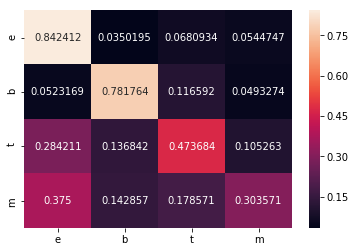

In [101]:
df_cfm = pd.DataFrame(cfm_data,index=labels,columns=labels)
sns.heatmap(df_cfm,fmt="g",annot=True)
plt.show()

# 56 適合率、再現率、F1

macro クラスごと　　
micro　全体

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## 適合率
$$
    accuracy = \frac{TP}{TP+FP}
$$
 

In [78]:
precision_macro = precision_score(y_true,y_pred,average="macro")
precision_macro

0.8308519659035123

In [79]:
precision_micro = precision_score(y_true,y_pred,average="micro")
precision_micro

0.876311844077961

## 再現率

In [80]:
recall_macro = recall_score(y_true,y_pred,average="macro")
recall_macro

0.7883080204989085

In [81]:
recall_micro = recall_score(y_true,y_pred,average="micro")
recall_micro

0.876311844077961

## F1

In [82]:
f1_macro = f1_score(y_true,y_pred,average="macro")
f1_macro

0.8068265309727649

In [83]:
f1_micro = f1_score(y_true,y_pred,average="micro")
f1_micro

0.876311844077961

# 57 特徴量の重み

In [0]:
weight_data = pd.DataFrame(clf.coef_,index=labels,columns=train_feature.columns).T

In [85]:
weight_data.head()

,e,b,t,m
HOSTNAME_in.reuters.com,-3.840169,2.875627,0.005746,-1.465449
HOSTNAME_www.businessweek.com,-3.212257,2.514901,-0.003238,-0.126873
HOSTNAME_www.contactmusic.com,6.401100,-7.846454,-3.905499,-3.326907
HOSTNAME_www.dailymail.co.uk,1.059947,-0.828911,0.662807,1.382643
HOSTNAME_www.huffingtonpost.com,0.756075,-0.386162,0.663963,1.306557


## top10

In [0]:
cate_e = weight_data["e"].map(abs).sort_values().index

In [0]:
cate_data = pd.DataFrame()

In [0]:
for col in weight_data.columns:
    cate_data[col] = weight_data[col].map(abs).sort_values().index

In [89]:
cate_data.tail(10)[::-1]

,e,b,t,m
4940,waterloo,amedisi,neutral,amedisi
4939,captain,unshaken,croak,actor
4938,maureen,neutral,activis,petco
4937,apart,nearmiss,throne,fda
4936,harrison,twitch,havent,schumach
4935,emmi,wire,seismic,gulp
4934,festiv,realiti,xiaomi,alzheim
4933,powder,denni,na,mer
4932,kim,presenc,respons,glass
4931,katherin,aereo,heartble,laps


In [90]:
cate_data.head(10)

,e,b,t,m
0,wwwentertainmentwisecom,httpradaronlinecomphotossolangeattackjayzbeyon...,on,httpwwwentertainmentwisecomnewsnotsodrunkinlov...
1,httpradaronlinecomphotossolangeattackjayzbeyon...,wwwentertainmentwisecom,wwwentertainmentwisecom,httpradaronlinecomphotossolangeattackjayzbeyon...
2,on,radaronlinecom,httpwwwentertainmentwisecomnewsnotsodrunkinlov...,httpwwwcrushablecomentertainmentsolangeattackm...
3,httpwwwcrushablecomentertainmentsolangeattackm...,httpwwwcrushablecomentertainmentsolangeattackm...,httpwwwcrushablecomentertainmentsolangeattackm...,wwwentertainmentwisecom
4,httpwwwentertainmentwisecomnewsnotsodrunkinlov...,on,httpradaronlinecomphotossolangeattackjayzbeyon...,radaronlinecom
5,radaronlinecom,httpwwwentertainmentwisecomnewsnotsodrunkinlov...,radaronlinecom,on
6,bonaroo,omara,blige,blige
7,blige,destini,bonaroo,meme
8,unwittingli,burglari,rebelli,pinewood
9,meme,sinatra,starpack,bonaroo


 # 58 正則化パラメータの変更

In [0]:
res_train=[]
res_test=[]

In [0]:
wid = 10**3
range_list = range(wid,wid*10,wid)

In [0]:
res_train=[]
res_test=[]
for c in range_list:
    clf = sklearn.linear_model.LogisticRegression(C=c)
    clf.fit(train_feature,train_target)
    res_train.append(clf.score(train_feature,train_target))
    res_test.append(clf.score(test_feature,test_target))



*   リスト項目
*   リスト項目



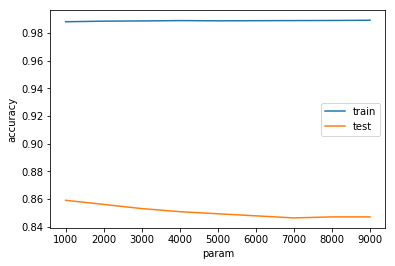

In [94]:
plt.plot(range_list,res_train,label="train")
plt.plot(range_list,res_test,label="test")
plt.xlabel("param")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# 59 ハイパーパラメータの探索

In [0]:
# K nearest neighbors法

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [0]:
knn = KNeighborsClassifier(n_neighbors=6) # インスタンス生成。n_neighbors:Kの数
knn.fit(train_feature, train_target)                 # モデル作成実行
y_pred = knn.predict(test_feature)              # 予測実行

In [98]:
accuracy_score(y_pred,test_target)

0.7728635682158921

In [99]:
for k in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=k) # インスタンス生成。n_neighbors:Kの数
    knn.fit(train_feature, train_target)                 # モデル作成実行
    y_pred = knn.predict(test_feature)              # 予測実行
    print("k=",k,"acc-",accuracy_score(y_pred,test_target))

k= 1 acc- 0.7586206896551724
k= 2 acc- 0.7623688155922039
k= 3 acc- 0.7706146926536732
k= 4 acc- 0.7781109445277361
k= 5 acc- 0.7758620689655172
k= 6 acc- 0.7728635682158921
k= 7 acc- 0.7683658170914542
k= 8 acc- 0.7766116941529235
k= 9 acc- 0.7631184407796102
